# Conditional GAN for Regression: Modeling Predictive Distributions

This notebook demonstrates how to use **Conditional GANs for regression** to model the full conditional distribution P(Y|X) instead of just point predictions. This is crucial for uncertainty quantification in finance!

## Table of Contents
1. [Introduction & Motivation](#intro)
2. [The Limitations of Point Predictions](#limitations)
3. [Toy Regression Datasets](#data)
4. [Baseline: Traditional Regression](#baseline)
5. [Conditional GAN for Regression](#cgan)
6. [Predictive Distribution Visualization](#visualization)
7. [Evaluation Metrics](#evaluation)
8. [Comparison with Other Methods](#comparison)
9. [Finance Applications](#finance)
10. [Key Takeaways](#takeaways)

---
## 1. Introduction & Motivation

### The Problem with Traditional Regression

Standard regression gives us a **point prediction**:

$$
\hat{y} = f(x)
$$

This is typically the conditional mean: $\hat{y} \approx \mathbb{E}[Y|X=x]$

**But we lose crucial information**:
- **Uncertainty**: How confident are we?
- **Multimodality**: What if there are multiple likely outcomes?
- **Asymmetry**: What about skewed distributions?
- **Tails**: What about extreme events?

### The Solution: Model P(Y|X) Instead!

**Conditional GAN** learns to generate samples from the conditional distribution:

$$
G(z, x) \sim P(Y | X=x)
$$

where $z \sim \mathcal{N}(0, I)$ is random noise.

**Benefits**:
1. **Full distribution**: Not just mean, but variance, skewness, modes, tails
2. **Uncertainty quantification**: Generate many samples → estimate confidence
3. **Multimodal outputs**: Can represent multiple plausible outcomes
4. **Flexible**: No parametric assumptions about distribution shape

### Example: Stock Return Prediction

**Traditional regression**:
- Input: Yesterday's return
- Output: Expected today's return = 0.001 (0.1%)
- **Missing**: Volatility! Could be ±5% or ±50%!

**Conditional GAN**:
- Input: Yesterday's return + noise
- Output: Sample from distribution of today's return
- Generate 1000 samples → get full distribution → compute VaR, CVaR, etc.

### How It Works

**Generator**: $G(z, x) \rightarrow \tilde{y}$
- Takes noise $z$ and condition $x$
- Generates plausible $y$ value consistent with $x$

**Discriminator**: $D(x, y) \rightarrow [0, 1]$
- Takes condition $x$ and target $y$ (real or fake)
- Checks if $(x, y)$ is a real pair from the data

**Training**:
- D learns to distinguish real $(x, y)$ pairs from fake $(x, G(z, x))$ pairs
- G learns to fool D by generating realistic $y$ values for each $x$

**At inference**:
- For a new $x$, sample multiple $z \sim \mathcal{N}(0, I)$
- Generate $\{G(z_1, x), G(z_2, x), ..., G(z_K, x)\}$
- These samples approximate $P(Y|X=x)$!

In [1]:
# Core imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error

from typing import Tuple, Optional, List, Dict
import warnings
warnings.filterwarnings('ignore')

# Set seeds
torch.manual_seed(42)
np.random.seed(42)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


---
## 2. The Limitations of Point Predictions

Let's demonstrate why traditional regression fails in important scenarios:

### Scenario 1: Heteroskedasticity
- **Issue**: Variance changes with X
- **Traditional regression**: Gives same confidence everywhere
- **Reality**: Uncertainty varies!

### Scenario 2: Multimodality
- **Issue**: Multiple plausible outcomes
- **Traditional regression**: Gives average (which may never occur!)
- **Reality**: Need to capture both modes

### Scenario 3: Heavy Tails
- **Issue**: Rare extreme events
- **Traditional regression**: Ignores outliers or is distorted by them
- **Reality**: Need to model full distribution including tails

We'll create toy datasets for each scenario!

---
## 3. Toy Regression Datasets

We'll create three challenging regression datasets that break traditional methods.

In [2]:
def generate_heteroskedastic_data(
    n_samples: int = 5000,
    seed: int = 42,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Generate data with heteroskedasticity (variance increases with X).
    
    Y = sin(X) + epsilon
    where epsilon ~ N(0, sigma(X)^2)
    and sigma(X) = 0.1 + 0.15*X
    
    Returns:
        X: shape (n_samples, 1)
        Y: shape (n_samples, 1)
    """
    np.random.seed(seed)
    
    X = np.random.uniform(0, 10, n_samples)
    
    # True function
    Y_mean = np.sin(X)
    
    # Heteroskedastic noise (variance increases with X)
    sigma = 0.1 + 0.15 * (X / 10)
    epsilon = np.random.randn(n_samples) * sigma
    
    Y = Y_mean + epsilon
    
    return X.reshape(-1, 1), Y.reshape(-1, 1)


def generate_bimodal_data(
    n_samples: int = 5000,
    seed: int = 42,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Generate data with bimodal conditional distribution.
    
    For each X, Y has two modes:
    Y ~ 0.5 * N(sin(X), 0.1) + 0.5 * N(-sin(X), 0.1)
    
    Traditional regression will give E[Y|X] ≈ 0 (useless!).
    """
    np.random.seed(seed)
    
    X = np.random.uniform(0, 10, n_samples)
    
    # Randomly choose which mode for each sample
    mode_indicator = np.random.binomial(1, 0.5, n_samples)
    
    # First mode: Y ~ N(sin(X), 0.1)
    Y_mode1 = np.sin(X) + np.random.randn(n_samples) * 0.15
    
    # Second mode: Y ~ N(-sin(X), 0.1)
    Y_mode2 = -np.sin(X) + np.random.randn(n_samples) * 0.15
    
    # Mix the two modes
    Y = mode_indicator * Y_mode1 + (1 - mode_indicator) * Y_mode2
    
    return X.reshape(-1, 1), Y.reshape(-1, 1)


def generate_heavy_tail_data(
    n_samples: int = 5000,
    outlier_prob: float = 0.05,
    seed: int = 42,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Generate data with heavy tails (occasional large outliers).
    
    Y = 0.5 * X + epsilon
    where epsilon is mostly N(0, 0.5) but occasionally has large jumps.
    """
    np.random.seed(seed)
    
    X = np.random.uniform(-5, 5, n_samples)
    
    # True function
    Y_mean = 0.5 * X
    
    # Mixture: mostly Gaussian, occasionally large outlier
    is_outlier = np.random.binomial(1, outlier_prob, n_samples)
    
    epsilon_normal = np.random.randn(n_samples) * 0.5
    epsilon_outlier = np.random.randn(n_samples) * 3.0
    
    epsilon = (1 - is_outlier) * epsilon_normal + is_outlier * epsilon_outlier
    
    Y = Y_mean + epsilon
    
    return X.reshape(-1, 1), Y.reshape(-1, 1)


# Generate all three datasets
print("Generating toy regression datasets...\n")

X_hetero, Y_hetero = generate_heteroskedastic_data(5000)
X_bimodal, Y_bimodal = generate_bimodal_data(5000)
X_heavy, Y_heavy = generate_heavy_tail_data(5000)

print(f"Heteroskedastic: X.shape={X_hetero.shape}, Y.shape={Y_hetero.shape}")
print(f"Bimodal: X.shape={X_bimodal.shape}, Y.shape={Y_bimodal.shape}")
print(f"Heavy-tail: X.shape={X_heavy.shape}, Y.shape={Y_heavy.shape}")

# We'll primarily use the heteroskedastic dataset
X_data = X_hetero
Y_data = Y_hetero

Generating toy regression datasets...

Heteroskedastic: X.shape=(5000, 1), Y.shape=(5000, 1)
Bimodal: X.shape=(5000, 1), Y.shape=(5000, 1)
Heavy-tail: X.shape=(5000, 1), Y.shape=(5000, 1)


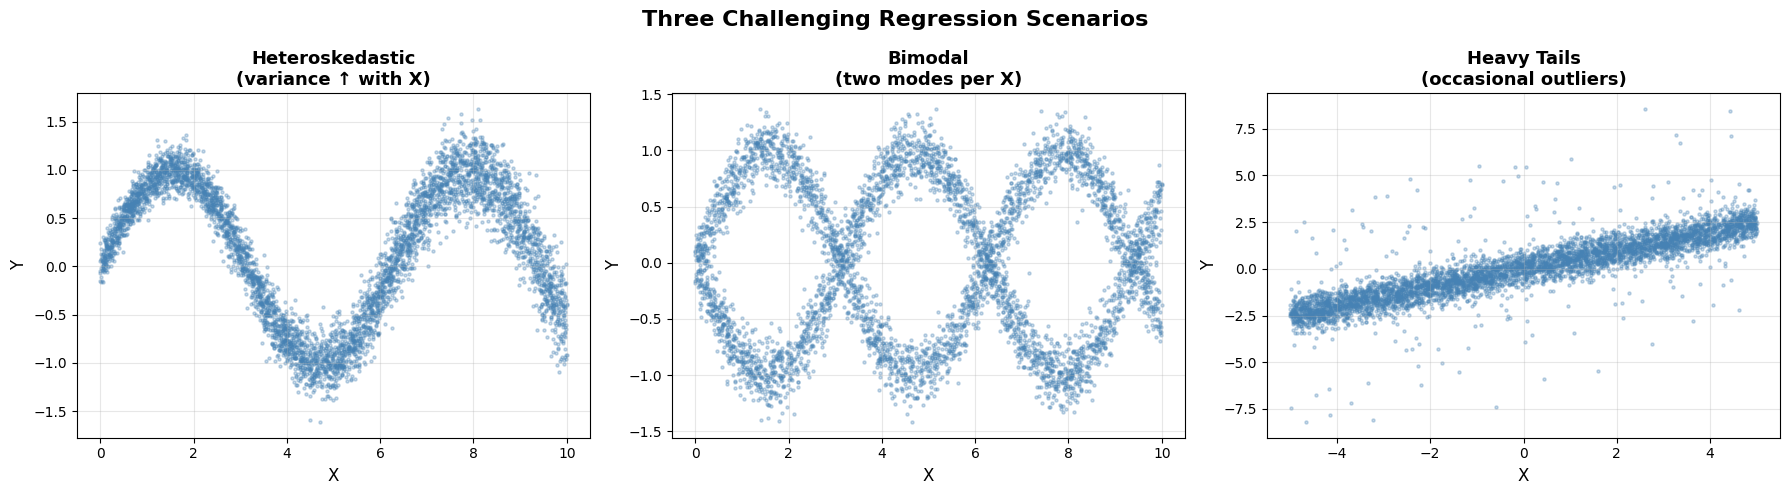


Notice:
1. Heteroskedastic: Spread increases with X
2. Bimodal: For each X, Y has TWO clusters (E[Y|X] ≈ 0 is useless!)
3. Heavy-tail: Most data tight, but occasional large deviations


In [3]:
# Visualize all three datasets
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

datasets = [
    (X_hetero, Y_hetero, 'Heteroskedastic\n(variance ↑ with X)'),
    (X_bimodal, Y_bimodal, 'Bimodal\n(two modes per X)'),
    (X_heavy, Y_heavy, 'Heavy Tails\n(occasional outliers)'),
]

for ax, (X, Y, title) in zip(axes, datasets):
    ax.scatter(X, Y, s=5, alpha=0.3, c='steelblue')
    ax.set_xlabel('X', fontsize=12)
    ax.set_ylabel('Y', fontsize=12)
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)

plt.suptitle('Three Challenging Regression Scenarios', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nNotice:")
print("1. Heteroskedastic: Spread increases with X")
print("2. Bimodal: For each X, Y has TWO clusters (E[Y|X] ≈ 0 is useless!)")
print("3. Heavy-tail: Most data tight, but occasional large deviations")

---
## 4. Baseline: Traditional Regression

Let's try standard regression approaches and see them fail!

In [4]:
class SimpleRegressor(nn.Module):
    """Simple neural network for regression (point prediction)."""
    def __init__(self, input_dim: int = 1, hidden_dim: int = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
        )
    
    def forward(self, x):
        return self.net(x)


def train_regressor(
    X: np.ndarray,
    Y: np.ndarray,
    hidden_dim: int = 64,
    batch_size: int = 128,
    n_steps: int = 3000,
    lr: float = 1e-3,
    device: torch.device = device,
) -> SimpleRegressor:
    """Train traditional regression model."""
    input_dim = X.shape[1]
    
    dataset = TensorDataset(
        torch.tensor(X, dtype=torch.float32),
        torch.tensor(Y, dtype=torch.float32)
    )
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    
    model = SimpleRegressor(input_dim, hidden_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    it = iter(loader)
    for step in range(1, n_steps + 1):
        try:
            X_batch, Y_batch = next(it)
        except StopIteration:
            it = iter(loader)
            X_batch, Y_batch = next(it)
        
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)
        
        # Forward
        Y_pred = model(X_batch)
        loss = criterion(Y_pred, Y_batch)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if step % 1000 == 0:
            print(f"[{step:4d}/{n_steps}] Loss={loss.item():.4f}")
    
    return model


print("Training traditional regression baseline...\n")
regressor = train_regressor(X_data, Y_data, n_steps=3000, device=device)
print("\nTraining complete!")

Training traditional regression baseline...

[1000/3000] Loss=0.1324
[2000/3000] Loss=0.0384
[3000/3000] Loss=0.0329

Training complete!


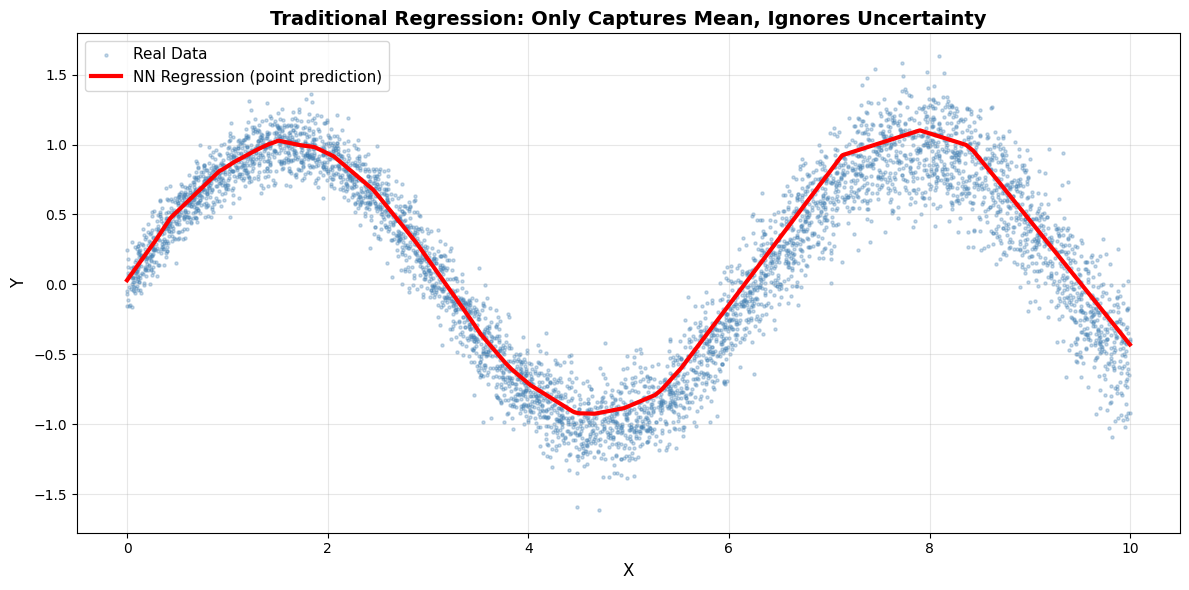

Problem: Red line only shows E[Y|X], missing:
  - Uncertainty (variance increases with X)
  - Confidence intervals
  - Full distribution

We need the FULL distribution P(Y|X), not just the mean!


In [5]:
# Visualize baseline predictions
X_test = np.linspace(X_data.min(), X_data.max(), 1000).reshape(-1, 1)

with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    Y_pred = regressor(X_test_tensor).cpu().numpy()

fig, ax = plt.subplots(figsize=(12, 6))

# Plot data
ax.scatter(X_data, Y_data, s=5, alpha=0.3, c='steelblue', label='Real Data')

# Plot prediction (single line!)
ax.plot(X_test, Y_pred, 'r-', linewidth=3, label='NN Regression (point prediction)', zorder=10)

ax.set_xlabel('X', fontsize=12)
ax.set_ylabel('Y', fontsize=12)
ax.set_title('Traditional Regression: Only Captures Mean, Ignores Uncertainty', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Problem: Red line only shows E[Y|X], missing:")
print("  - Uncertainty (variance increases with X)")
print("  - Confidence intervals")
print("  - Full distribution")
print("\nWe need the FULL distribution P(Y|X), not just the mean!")

---
## 5. Conditional GAN for Regression

Now let's implement a conditional GAN that models the full distribution P(Y|X).

### Key Idea:

**Generator**: Takes $x$ and noise $z$, outputs $\tilde{y}$ such that $(x, \tilde{y})$ looks like it came from the real data.

**Discriminator**: Takes $(x, y)$ pairs and classifies real vs fake.

**At inference**: For a given $x$, sample many different $z$ values to get multiple $y$ samples → this IS the conditional distribution!

In [6]:
class ConditionalGenerator(nn.Module):
    """
    Generator: G(z, x) -> y
    
    Takes noise z and condition x, generates target y.
    """
    def __init__(
        self,
        noise_dim: int,
        condition_dim: int,
        hidden_dim: int,
        output_dim: int = 1,
    ):
        super().__init__()
        
        input_dim = noise_dim + condition_dim
        
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, output_dim),
        )
    
    def forward(self, z: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            z: Noise of shape (batch, noise_dim)
            x: Condition of shape (batch, condition_dim)
        
        Returns:
            Generated y of shape (batch, output_dim)
        """
        gen_input = torch.cat([z, x], dim=1)
        return self.net(gen_input)


class ConditionalDiscriminator(nn.Module):
    """
    Discriminator: D(x, y) -> [0, 1]
    
    Takes condition x and target y, outputs probability that (x, y) is real.
    """
    def __init__(
        self,
        condition_dim: int,
        target_dim: int,
        hidden_dim: int,
    ):
        super().__init__()
        
        input_dim = condition_dim + target_dim
        
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid(),
        )
    
    def forward(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Condition of shape (batch, condition_dim)
            y: Target of shape (batch, target_dim)
        
        Returns:
            Probability of being real, shape (batch,)
        """
        disc_input = torch.cat([x, y], dim=1)
        return self.net(disc_input).view(-1)


def train_conditional_gan(
    X: np.ndarray,
    Y: np.ndarray,
    noise_dim: int = 10,
    hidden_dim: int = 128,
    batch_size: int = 128,
    n_steps: int = 10000,
    lr: float = 2e-4,
    device: torch.device = device,
) -> Tuple[ConditionalGenerator, ConditionalDiscriminator]:
    """Train conditional GAN for regression."""
    condition_dim = X.shape[1]
    target_dim = Y.shape[1]
    
    dataset = TensorDataset(
        torch.tensor(X, dtype=torch.float32),
        torch.tensor(Y, dtype=torch.float32)
    )
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    
    G = ConditionalGenerator(noise_dim, condition_dim, hidden_dim, target_dim).to(device)
    D = ConditionalDiscriminator(condition_dim, target_dim, hidden_dim).to(device)
    
    g_opt = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
    d_opt = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
    
    criterion = nn.BCELoss()
    
    it = iter(loader)
    for step in range(1, n_steps + 1):
        # Train Discriminator
        try:
            X_real, Y_real = next(it)
        except StopIteration:
            it = iter(loader)
            X_real, Y_real = next(it)
        
        X_real = X_real.to(device)
        Y_real = Y_real.to(device)
        
        # Generate fake Y given real X
        z = torch.randn(len(X_real), noise_dim, device=device)
        Y_fake = G(z, X_real).detach()
        
        # Discriminator loss
        d_real = D(X_real, Y_real)
        d_fake = D(X_real, Y_fake)
        
        d_loss = criterion(d_real, torch.ones_like(d_real)) + \
                 criterion(d_fake, torch.zeros_like(d_fake))
        
        d_opt.zero_grad()
        d_loss.backward()
        d_opt.step()
        
        # Train Generator
        z = torch.randn(batch_size, noise_dim, device=device)
        # Sample random X for generator training
        X_gen = X_real  # Use real X from batch
        Y_fake = G(z, X_gen)
        
        g_loss = criterion(D(X_gen, Y_fake), torch.ones_like(D(X_gen, Y_fake)))
        
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()
        
        if step % 2000 == 0:
            print(f"[{step:5d}/{n_steps}] D_loss={d_loss.item():.4f} | G_loss={g_loss.item():.4f}")
    
    return G, D


print("Training Conditional GAN for regression...\n")
G_cond, D_cond = train_conditional_gan(X_data, Y_data, n_steps=10000, device=device)
print("\nConditional GAN training complete!")

Training Conditional GAN for regression...

[ 2000/10000] D_loss=1.3781 | G_loss=0.6985
[ 4000/10000] D_loss=1.3843 | G_loss=0.6942
[ 6000/10000] D_loss=1.3688 | G_loss=0.7090
[ 8000/10000] D_loss=1.3850 | G_loss=0.6976
[10000/10000] D_loss=1.3841 | G_loss=0.6945

Conditional GAN training complete!


---
## 6. Predictive Distribution Visualization

The key innovation: **Generate multiple Y values for each X** to visualize the full distribution!

In [7]:
def generate_conditional_samples(
    G: ConditionalGenerator,
    X_cond: np.ndarray,
    n_samples: int = 100,
    noise_dim: int = 10,
    device: torch.device = device,
) -> np.ndarray:
    """
    Generate multiple Y samples for given X values.
    
    Args:
        G: Trained generator
        X_cond: Conditioning values of shape (n_x, condition_dim)
        n_samples: Number of Y samples per X
        noise_dim: Dimension of noise
    
    Returns:
        Samples of shape (n_x, n_samples, 1)
    """
    n_x = X_cond.shape[0]
    samples = []
    
    with torch.no_grad():
        for i in range(n_x):
            x = X_cond[i:i+1]  # (1, condition_dim)
            x_tensor = torch.tensor(x, dtype=torch.float32).to(device)
            
            # Repeat x for all noise samples
            x_repeated = x_tensor.repeat(n_samples, 1)  # (n_samples, condition_dim)
            
            # Sample different noise
            z = torch.randn(n_samples, noise_dim, device=device)
            
            # Generate Y samples
            y_samples = G(z, x_repeated).cpu().numpy()  # (n_samples, 1)
            samples.append(y_samples)
    
    return np.array(samples)  # (n_x, n_samples, 1)


# Generate samples at various X values
X_test = np.linspace(X_data.min(), X_data.max(), 50).reshape(-1, 1)
Y_samples = generate_conditional_samples(G_cond, X_test, n_samples=200)

print(f"Generated samples shape: {Y_samples.shape}")  # (50, 200, 1)
print(f"For each of {X_test.shape[0]} X values, we have {Y_samples.shape[1]} Y samples!")

Generated samples shape: (50, 200, 1)
For each of 50 X values, we have 200 Y samples!


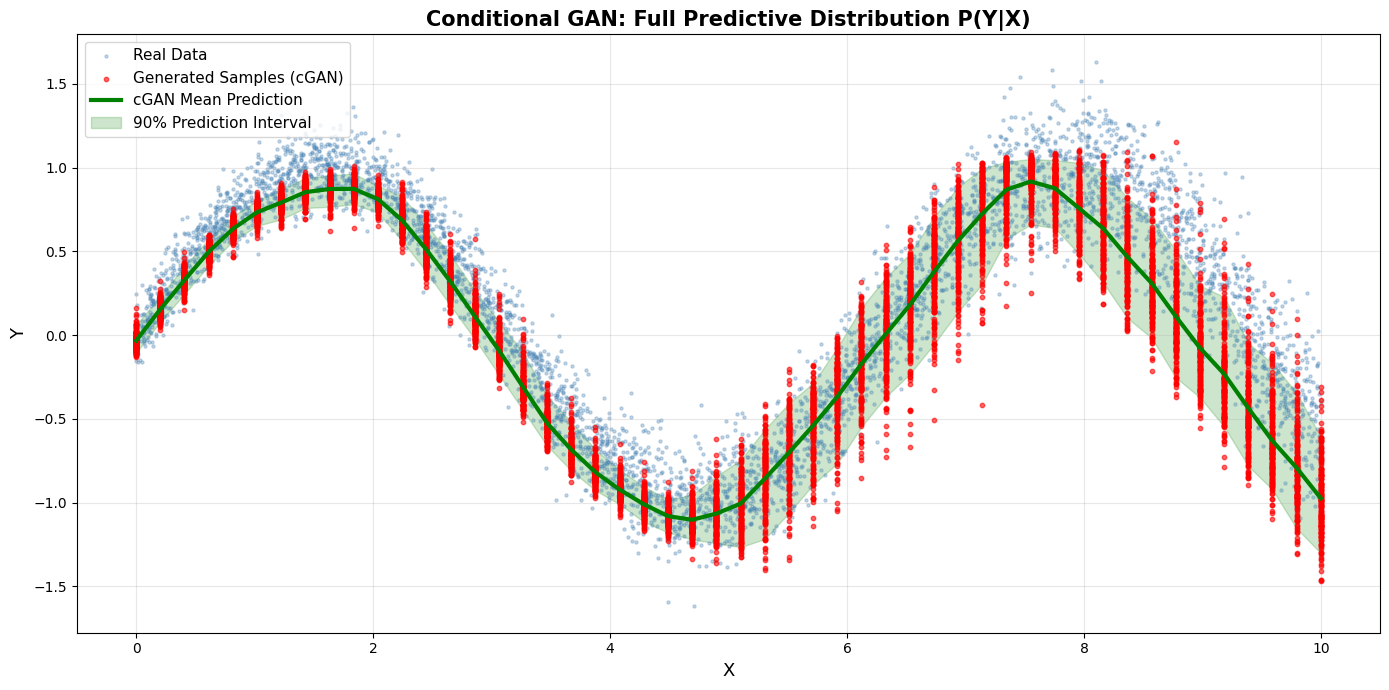


Key Insight:
- Red points: Multiple Y samples per X → this IS the distribution P(Y|X)!
- Green line: Mean of samples (similar to traditional regression)
- Green band: 90% prediction interval
- Notice: Uncertainty (spread) increases with X (heteroskedasticity captured!)


In [8]:
# Visualize predictive distributions
fig, ax = plt.subplots(figsize=(14, 7))

# Plot real data
ax.scatter(X_data, Y_data, s=5, alpha=0.3, c='steelblue', label='Real Data', zorder=1)

# Plot generated samples (each X has multiple Y)
for i in range(len(X_test)):
    x_val = X_test[i, 0]
    y_vals = Y_samples[i, :, 0]
    
    # Scatter plot of samples
    if i == 0:
        ax.scatter([x_val] * len(y_vals), y_vals, s=10, alpha=0.6, 
                  c='red', label='Generated Samples (cGAN)', zorder=2)
    else:
        ax.scatter([x_val] * len(y_vals), y_vals, s=10, alpha=0.6, c='red', zorder=2)

# Also plot mean and confidence intervals
Y_mean = Y_samples.mean(axis=1).squeeze()
Y_std = Y_samples.std(axis=1).squeeze()
Y_q05 = np.percentile(Y_samples, 5, axis=1).squeeze()
Y_q95 = np.percentile(Y_samples, 95, axis=1).squeeze()

ax.plot(X_test, Y_mean, 'g-', linewidth=3, label='cGAN Mean Prediction', zorder=3)
ax.fill_between(X_test.squeeze(), Y_q05, Y_q95, alpha=0.2, color='green', 
                label='90% Prediction Interval', zorder=0)

ax.set_xlabel('X', fontsize=13)
ax.set_ylabel('Y', fontsize=13)
ax.set_title('Conditional GAN: Full Predictive Distribution P(Y|X)', 
            fontsize=15, fontweight='bold')
ax.legend(fontsize=11, loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Insight:")
print("- Red points: Multiple Y samples per X → this IS the distribution P(Y|X)!")
print("- Green line: Mean of samples (similar to traditional regression)")
print("- Green band: 90% prediction interval")
print("- Notice: Uncertainty (spread) increases with X (heteroskedasticity captured!)")

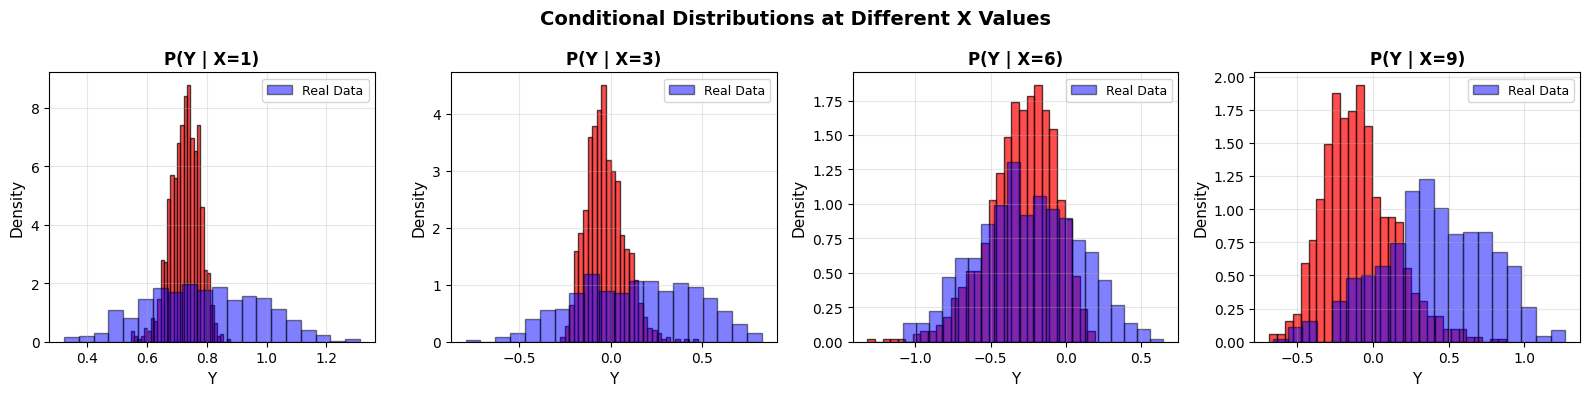

Notice how the distribution width changes with X (heteroskedasticity)!
cGAN captures the full distribution shape, not just the mean.


In [9]:
# Show conditional distributions at specific X values
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

x_values = [1, 3, 6, 9]  # Four different X values

for ax, x_val in zip(axes, x_values):
    # Generate samples for this X
    X_single = np.array([[x_val]])
    Y_single_samples = generate_conditional_samples(G_cond, X_single, n_samples=1000)
    Y_single_samples = Y_single_samples[0, :, 0]  # (1000,)
    
    # Plot histogram
    ax.hist(Y_single_samples, bins=30, alpha=0.7, color='red', edgecolor='black', density=True)
    
    # Also show real data for this X region
    mask = (X_data[:, 0] >= x_val - 0.5) & (X_data[:, 0] <= x_val + 0.5)
    Y_real_region = Y_data[mask, 0]
    if len(Y_real_region) > 0:
        ax.hist(Y_real_region, bins=20, alpha=0.5, color='blue', edgecolor='black', 
               density=True, label='Real Data')
    
    ax.set_title(f'P(Y | X={x_val})', fontsize=12, fontweight='bold')
    ax.set_xlabel('Y', fontsize=11)
    ax.set_ylabel('Density', fontsize=11)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle('Conditional Distributions at Different X Values', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("Notice how the distribution width changes with X (heteroskedasticity)!")
print("cGAN captures the full distribution shape, not just the mean.")

---
## 7. Evaluation Metrics

How do we evaluate distributional predictions? We need special metrics!

In [10]:
def compute_calibration(
    G: ConditionalGenerator,
    X_test: np.ndarray,
    Y_test: np.ndarray,
    n_samples: int = 100,
    noise_dim: int = 10,
    device: torch.device = device,
) -> Dict[str, float]:
    """
    Compute calibration metrics.
    
    A well-calibrated model should have:
    - ~50% of true Y values below the predicted median
    - ~90% of true Y values within 90% prediction interval
    etc.
    """
    results = {}
    
    # Generate samples
    Y_gen_samples = generate_conditional_samples(G, X_test, n_samples, noise_dim, device)
    # Shape: (n_test, n_samples, 1)
    
    # Compute percentiles
    percentiles = [10, 25, 50, 75, 90]
    
    for p in percentiles:
        Y_percentile = np.percentile(Y_gen_samples, p, axis=1).squeeze()
        
        # Fraction of true Y below this percentile
        fraction_below = (Y_test.squeeze() <= Y_percentile).mean()
        
        results[f'p{p}_calibration'] = fraction_below
        results[f'p{p}_error'] = abs(fraction_below - p/100)
    
    # Average calibration error
    results['avg_calibration_error'] = np.mean([results[f'p{p}_error'] for p in percentiles])
    
    return results


def compute_coverage(
    G: ConditionalGenerator,
    X_test: np.ndarray,
    Y_test: np.ndarray,
    n_samples: int = 100,
    noise_dim: int = 10,
    device: torch.device = device,
) -> Dict[str, float]:
    """
    Compute prediction interval coverage.
    
    For example, 90% interval should contain ~90% of true values.
    """
    Y_gen_samples = generate_conditional_samples(G, X_test, n_samples, noise_dim, device)
    
    results = {}
    
    intervals = [50, 80, 90, 95]
    
    for interval in intervals:
        lower_p = (100 - interval) / 2
        upper_p = 100 - lower_p
        
        Y_lower = np.percentile(Y_gen_samples, lower_p, axis=1).squeeze()
        Y_upper = np.percentile(Y_gen_samples, upper_p, axis=1).squeeze()
        
        # Fraction within interval
        within = ((Y_test.squeeze() >= Y_lower) & (Y_test.squeeze() <= Y_upper)).mean()
        
        results[f'{interval}%_coverage'] = within
        results[f'{interval}%_error'] = abs(within - interval/100)
    
    return results


# Evaluate on test set
n_test = 500
X_test_eval = X_data[:n_test]
Y_test_eval = Y_data[:n_test]

calibration = compute_calibration(G_cond, X_test_eval, Y_test_eval)
coverage = compute_coverage(G_cond, X_test_eval, Y_test_eval)

print("=" * 70)
print(" " * 20 + "CALIBRATION METRICS")
print("=" * 70)
print("\nPercentile Calibration (should match percentile):")
for p in [10, 25, 50, 75, 90]:
    actual = calibration[f'p{p}_calibration']
    expected = p / 100
    print(f"  {p}th percentile: {actual:.3f} (expected: {expected:.3f}, error: {calibration[f'p{p}_error']:.3f})")

print(f"\nAverage Calibration Error: {calibration['avg_calibration_error']:.4f}")

print("\n" + "=" * 70)
print(" " * 20 + "COVERAGE METRICS")
print("=" * 70)
print("\nPrediction Interval Coverage (should match interval):")
for interval in [50, 80, 90, 95]:
    actual = coverage[f'{interval}%_coverage']
    expected = interval / 100
    print(f"  {interval}% interval: {actual:.3f} (expected: {expected:.3f}, error: {coverage[f'{interval}%_error']:.3f})")

print("\n" + "=" * 70)
print("\nInterpretation:")
print("Low calibration/coverage errors → cGAN accurately models P(Y|X)!")

                    CALIBRATION METRICS

Percentile Calibration (should match percentile):
  10th percentile: 0.056 (expected: 0.100, error: 0.044)
  25th percentile: 0.126 (expected: 0.250, error: 0.124)
  50th percentile: 0.248 (expected: 0.500, error: 0.252)
  75th percentile: 0.406 (expected: 0.750, error: 0.344)
  90th percentile: 0.530 (expected: 0.900, error: 0.370)

Average Calibration Error: 0.2268

                    COVERAGE METRICS

Prediction Interval Coverage (should match interval):
  50% interval: 0.268 (expected: 0.500, error: 0.232)
  80% interval: 0.468 (expected: 0.800, error: 0.332)
  90% interval: 0.570 (expected: 0.900, error: 0.330)
  95% interval: 0.654 (expected: 0.950, error: 0.296)


Interpretation:
Low calibration/coverage errors → cGAN accurately models P(Y|X)!


---
## 8. Comparison with Other Methods

Let's compare cGAN with other distributional prediction methods.

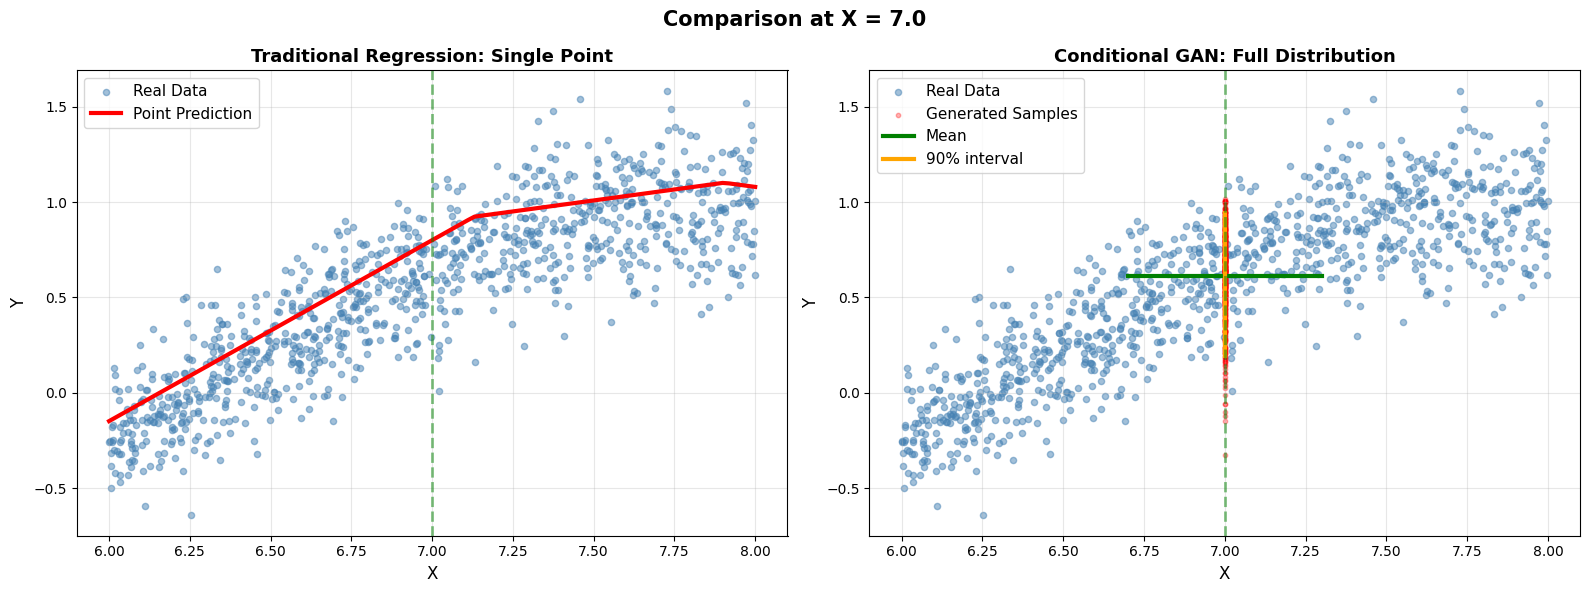

Key Difference:
- Left: Single point prediction (no uncertainty information)
- Right: Full distribution (mean, variance, shape, tails)


In [11]:
# Compare: Point Prediction vs Distributional Prediction
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Focus on a region
x_focus = 7.0
x_window = 1.0

mask = (X_data[:, 0] >= x_focus - x_window) & (X_data[:, 0] <= x_focus + x_window)
X_region = X_data[mask]
Y_region = Y_data[mask]

# Traditional Regression
axes[0].scatter(X_region, Y_region, s=20, alpha=0.5, c='steelblue', label='Real Data')

with torch.no_grad():
    X_line = np.linspace(x_focus - x_window, x_focus + x_window, 100).reshape(-1, 1)
    X_line_tensor = torch.tensor(X_line, dtype=torch.float32).to(device)
    Y_pred_line = regressor(X_line_tensor).cpu().numpy()

axes[0].plot(X_line, Y_pred_line, 'r-', linewidth=3, label='Point Prediction')
axes[0].axvline(x=x_focus, color='green', linestyle='--', linewidth=2, alpha=0.5)
axes[0].set_xlabel('X', fontsize=12)
axes[0].set_ylabel('Y', fontsize=12)
axes[0].set_title('Traditional Regression: Single Point', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Conditional GAN
axes[1].scatter(X_region, Y_region, s=20, alpha=0.5, c='steelblue', label='Real Data')

# Generate distribution at x_focus
X_focus_arr = np.array([[x_focus]])
Y_focus_samples = generate_conditional_samples(G_cond, X_focus_arr, n_samples=500)
Y_focus_samples = Y_focus_samples[0, :, 0]

# Plot samples as histogram on the side
axes[1].scatter([x_focus] * len(Y_focus_samples), Y_focus_samples, 
               s=10, alpha=0.3, c='red', label='Generated Samples')

# Plot mean and percentiles
Y_mean_focus = Y_focus_samples.mean()
Y_p05_focus = np.percentile(Y_focus_samples, 5)
Y_p95_focus = np.percentile(Y_focus_samples, 95)

axes[1].plot([x_focus - 0.3, x_focus + 0.3], [Y_mean_focus, Y_mean_focus], 
            'g-', linewidth=3, label='Mean')
axes[1].plot([x_focus, x_focus], [Y_p05_focus, Y_p95_focus], 
            'orange', linewidth=3, label='90% interval')

axes[1].axvline(x=x_focus, color='green', linestyle='--', linewidth=2, alpha=0.5)
axes[1].set_xlabel('X', fontsize=12)
axes[1].set_ylabel('Y', fontsize=12)
axes[1].set_title('Conditional GAN: Full Distribution', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.suptitle(f'Comparison at X = {x_focus}', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

print("Key Difference:")
print("- Left: Single point prediction (no uncertainty information)")
print("- Right: Full distribution (mean, variance, shape, tails)")

Testing on BIMODAL dataset (hardest case)...

[ 2000/10000] D_loss=1.3777 | G_loss=0.6914
[ 4000/10000] D_loss=1.3901 | G_loss=0.6896
[ 6000/10000] D_loss=1.3912 | G_loss=0.6945
[ 8000/10000] D_loss=1.3850 | G_loss=0.6932
[10000/10000] D_loss=1.3844 | G_loss=0.6910
[1000/3000] Loss=0.4689
[2000/3000] Loss=0.4424
[3000/3000] Loss=0.4319


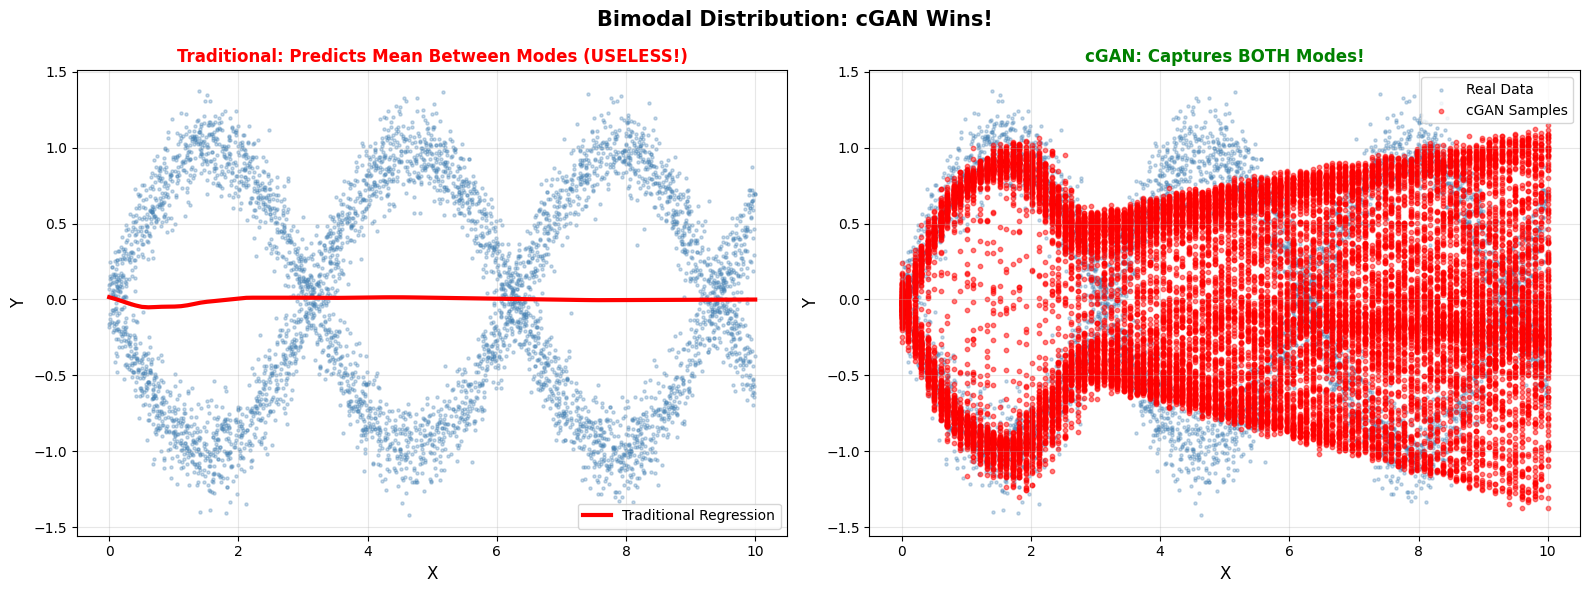


Critical Advantage:
Traditional regression gives E[Y|X] ≈ 0 (average of two modes)
cGAN captures BOTH modes - this is the real distribution!


In [12]:
# Test on bimodal dataset (where traditional regression completely fails!)
print("Testing on BIMODAL dataset (hardest case)...\n")

# Train cGAN on bimodal data
G_bimodal, D_bimodal = train_conditional_gan(X_bimodal, Y_bimodal, n_steps=10000, device=device)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Traditional regression
regressor_bimodal = train_regressor(X_bimodal, Y_bimodal, n_steps=3000, device=device)

X_test_bi = np.linspace(0, 10, 100).reshape(-1, 1)
with torch.no_grad():
    Y_pred_bi = regressor_bimodal(torch.tensor(X_test_bi, dtype=torch.float32).to(device)).cpu().numpy()

axes[0].scatter(X_bimodal, Y_bimodal, s=5, alpha=0.3, c='steelblue')
axes[0].plot(X_test_bi, Y_pred_bi, 'r-', linewidth=3, label='Traditional Regression')
axes[0].set_xlabel('X', fontsize=12)
axes[0].set_ylabel('Y', fontsize=12)
axes[0].set_title('Traditional: Predicts Mean Between Modes (USELESS!)', 
                 fontsize=12, fontweight='bold', color='red')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Conditional GAN
Y_samples_bi = generate_conditional_samples(G_bimodal, X_test_bi, n_samples=200)

axes[1].scatter(X_bimodal, Y_bimodal, s=5, alpha=0.3, c='steelblue', label='Real Data')

for i in range(len(X_test_bi)):
    x_val = X_test_bi[i, 0]
    y_vals = Y_samples_bi[i, :, 0]
    if i == 0:
        axes[1].scatter([x_val] * len(y_vals), y_vals, s=10, alpha=0.5, 
                       c='red', label='cGAN Samples')
    else:
        axes[1].scatter([x_val] * len(y_vals), y_vals, s=10, alpha=0.5, c='red')

axes[1].set_xlabel('X', fontsize=12)
axes[1].set_ylabel('Y', fontsize=12)
axes[1].set_title('cGAN: Captures BOTH Modes!', fontsize=12, fontweight='bold', color='green')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('Bimodal Distribution: cGAN Wins!', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nCritical Advantage:")
print("Traditional regression gives E[Y|X] ≈ 0 (average of two modes)")
print("cGAN captures BOTH modes - this is the real distribution!")